In [1]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools
import functools

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]
    
    if not restore_values:
        return
    
    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [4]:
# Not actual typevars, but just exist to satisfy the typechecker
N = typing.TypeVar('N')
M = typing.TypeVar('M')

In [13]:
@dataclass
class HermitInterp:
    """
    Note: `deriv_degrees` is the degree of the derivative at each point.
    `deriv_degrees[i] == 0` means that `ys[i] == f(xs[i])`.
    `deriv_degrees[i] == 1` means that `ys[i] == f'(xs[i])`, and so on.
    
    The program expects that if `deriv_degrees[i] == k > 0`, then it is
    immediately preceded by `deriv_degrees[i - 1] == k - 1`, `xs[i] == xs[i - 1]`,
    """
    
    xs: np.ndarray['N', float]
    ys: np.ndarray['N', float]
    deriv_degrees: np.ndarray['N', int]
    _f_cache: dict[typing.Tuple[int, ...], float] = field(default_factory=dict)
    
    def __post_init__(self) -> None:
        assert len(self.xs) == len(self.ys) == len(self.deriv_degrees)
        assert np.all(np.diff(self.xs) >= 0), "xs must be sorted"
    
    @classmethod
    def from_points(cls, xs: np.ndarray['N'], ys: np.ndarray['N']) -> HermitInterp:
        return cls(xs, ys, np.zeros_like(xs, dtype=int))
    
    @classmethod
    def from_points_with_derivs(cls, xs: np.ndarray, ys: np.ndarray, eps: float = 1e-8) -> HermitInterp:
        """
        Note: this factory considers that `ys[i]` specifies a derivative at `xs[i]`
        of `k`-th order (`k > 0`) if and only if `xs[i]` is `eps`-close to `xs[i - 1]`,
        and `ys[i - 1]` specifies a derivative of `k - 1`-st order. `0`-th order is
        assumed by default.
        """
        
        deriv_degrees: np.ndarray = np.zeros_like(xs, dtype=int)
        
        for i in range(1, len(xs)):
            if np.isclose(xs[i], xs[i - 1], atol=eps):
                deriv_degrees[i] = deriv_degrees[i - 1] + 1
        
        return cls(xs, ys, deriv_degrees)
    
    def _f_value(self, *point_idxs: tuple[int, ...]) -> float:
        point_idxs = tuple(point_idxs)
        
        if len(point_idxs) == 0:
            return 0
        
        if len(point_idxs) == 1:
            return self.ys[point_idxs[0] - self.deriv_degrees[point_idxs[0]]]
        
        if point_idxs in self._f_cache:
            return self._f_cache[point_idxs]
        
        result: float
        
        if self.deriv_degrees[point_idxs[-1]] - self.deriv_degrees[point_idxs[0]] == len(point_idxs) - 1:\
            # Hermitian special case
            
            assert np.isclose(self.xs[point_idxs[0]], self.xs[point_idxs[-1]], atol=1e-5),\
                "The x coordinate of a point with known derivatives must be consistent"
            
            result = self.ys[point_idxs[-1]] / np.math.factorial(len(point_idxs) - 1)
        else:
            result = self._f_value(*point_idxs[1:]) - self._f_value(*point_idxs[:-1])
            result /= self.xs[point_idxs[-1]] - self.xs[point_idxs[0]]
        
        self._f_cache[point_idxs] = result
        
        return result

    @functools.cached_property
    def poly(self) -> np.ndarray['N']:
        result: np.ndarray = np.zeros_like(self.xs)
        
        for i in range(len(self.xs)):
            result = np.polyadd(
                result,
                self._f_value(*range(i + 1)) * np.poly(self.xs[:i]),  # [self.deriv_degrees[np.arange(i)] == 0]
            )
        
        return result
    
    def __call__(self, x: np.ndarray['M']) -> np.ndarray['M']:
        return np.polyval(self.poly, x)


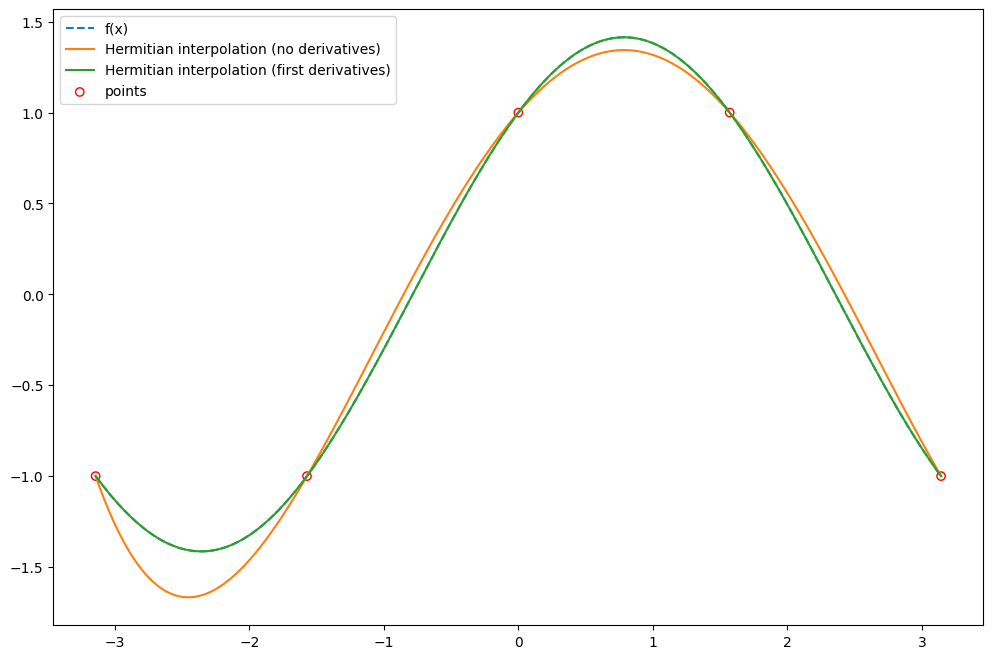

In [14]:
with localize_globals():
    f = lambda x: np.sin(x) + np.cos(x)
    df = lambda x: np.cos(x) - np.sin(x)
    n_points: int = 5
    grid = np.linspace(-np.pi, np.pi, 1000)
    xs = np.linspace(-np.pi, np.pi, n_points)
    
    # No derivatives
    interp_0 = HermitInterp.from_points(xs, f(xs))
    
    # First derivative at the each point
    xs_with_derivs = np.zeros(n_points * 2)
    ys_with_derivs = np.zeros(n_points * 2)
    
    xs_with_derivs[::2] = xs
    ys_with_derivs[::2] = f(xs)
    
    xs_with_derivs[1::2] = xs
    ys_with_derivs[1::2] = df(xs)
    
    interp_1 = HermitInterp.from_points_with_derivs(xs_with_derivs, ys_with_derivs)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.plot(grid, f(grid), label="f(x)", linestyle="--")
    ax.plot(grid, interp_0(grid), label="Hermitian interpolation (no derivatives)")
    ax.plot(grid, interp_1(grid), label="Hermitian interpolation (first derivatives)")
    
    ax.scatter(xs, f(xs), label="points", marker="o", c='None', edgecolors="red")
    
    ax.legend()
